# Using pgmpy for Bayesian inference

Documentation and examples for the package are available on [pgmpy.org](http://pgmpy.org/index.html). To [install](https://github.com/pgmpy/pgmpy#installation) using conda you need to add the `ankurankan` channel and install `pgmpy`. E.g. in the `environment.yml`:

``` yaml
name: aima_bayes
channels:
  - conda-forge
  - ankurankan
dependencies:
  - ...
  - pgmpy
```

or you can use the command:

```bash
conda install -c ankurankan pgmpy
```


Goal for this notebook:
- Implement a model
- Query it

In [1]:
import itertools

In [15]:
import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

## Compact representation

The known facts are

\\[b \iff \neg b_{1,1} \land b_{1,2} \land b_{2,1}\\]

\\[known \iff \neg p_{1,1} \land \neg p_{1,2} \land \neg p_{2,1}\\]

$b$ depends on $p_{1,3}, p_{2,2}, p_{3,1}$:

In [16]:
# first build the topology of your model
model = BayesianNetwork([('P13', 'B'), ('P22', 'B'), ('P31', 'B')])

### Define the $p_{ij}$

In [26]:
p_cpds = {}
for i in range(1,4):
    for j in range(1,4):
        p_cpds[(i, j)] = TabularCPD(
            variable=f'P{i}{j}', variable_card=2, 
            values=[[0.2], [0.8]], 
            state_names={f'P{i}{j}': [True, False]})

print(p_cpds[(1,1)])

+------------+-----+
| P11(True)  | 0.2 |
+------------+-----+
| P11(False) | 0.8 |
+------------+-----+


### Define $b$

Consider that

$$b_{1,1} \iff p_{1,2}\lor p_{2,1}$$
$$b_{1,2} \iff p_{1,1}\lor p_{2,2}\lor p_{1,3}$$
$$b_{2,1} \iff p_{1,1}\lor p_{2,2}\lor p_{3,1}$$

therefore, since $b \iff \neg b_{1,1} \land b_{1,2} \land b_{2,1}$

$$b \iff (p_{2,2}\lor p_{1,3})\land(p_{2,2}\lor p_{3,1})$$

because $\neg p_{1,1}, \neg p_{1,2}, \neg p_{2,1}$.





In [31]:
def b_table(p13, p22, p31):
    return (1.0, 0.0) if (p13 or p22) and (p22 or p31) else (0.0, 1.0)

print(tuple(zip(*[b_table(*ps) for ps in itertools.product((True, False), repeat=3)])))
b_cpd = TabularCPD(
    variable='B', variable_card=2,
    values=tuple(zip(*[b_table(*ps) for ps in itertools.product((True, False), repeat=3)])),
    evidence=['P13', 'P22', 'P31'],
    evidence_card=[2, 2, 2],
    state_names={
        'B': [True , False],
        'P13': [True, False],
        'P22': [True, False],
        'P31': [True, False]
    })

print(b_cpd)

((1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0))
+----------+-----------+------------+-----+------------+------------+
| P13      | P13(True) | P13(True)  | ... | P13(False) | P13(False) |
+----------+-----------+------------+-----+------------+------------+
| P22      | P22(True) | P22(True)  | ... | P22(False) | P22(False) |
+----------+-----------+------------+-----+------------+------------+
| P31      | P31(True) | P31(False) | ... | P31(True)  | P31(False) |
+----------+-----------+------------+-----+------------+------------+
| B(True)  | 1.0       | 1.0        | ... | 0.0        | 0.0        |
+----------+-----------+------------+-----+------------+------------+
| B(False) | 0.0       | 0.0        | ... | 1.0        | 1.0        |
+----------+-----------+------------+-----+------------+------------+


In [36]:
model.add_cpds(b_cpd, p_cpds[(1,3)], p_cpds[(2,2)], p_cpds[(3,1)])
model.check_model()

True

In [37]:
infer = VariableElimination(model)

### Queries

In [38]:
for v in ('P13', 'P22', 'P31'):
    print(infer.query([v], evidence={'B': True}, show_progress=False))

+------------+------------+
| P13        |   phi(P13) |
+============+============+
| P13(True)  |     0.3103 |
+------------+------------+
| P13(False) |     0.6897 |
+------------+------------+
+------------+------------+
| P22        |   phi(P22) |
+============+============+
| P22(True)  |     0.8621 |
+------------+------------+
| P22(False) |     0.1379 |
+------------+------------+
+------------+------------+
| P31        |   phi(P31) |
+============+============+
| P31(True)  |     0.3103 |
+------------+------------+
| P31(False) |     0.6897 |
+------------+------------+


## All variables

Now we consider all the variables in the domain, i.e. the $b_{i,j}$.

In [39]:
def cpd_values(bool_fn, arity):
    def bool_to_prob(*args) -> bool:
        return (1.0, 0.0) if bool_fn(*args) else (0.0, 1.0)
    
    return tuple(zip(*[bool_to_prob(*ps) for ps in itertools.product((True, False), repeat=arity)]))

def wumpus_cpd(name, evidence, bool_fn):
    return TabularCPD(
        variable=name, variable_card=2,
        values=cpd_values(bool_fn, len(evidence)),
        evidence=evidence, evidence_card=[2] * len(evidence),
        state_names={n: [True, False] for n in [name] + evidence}
    )

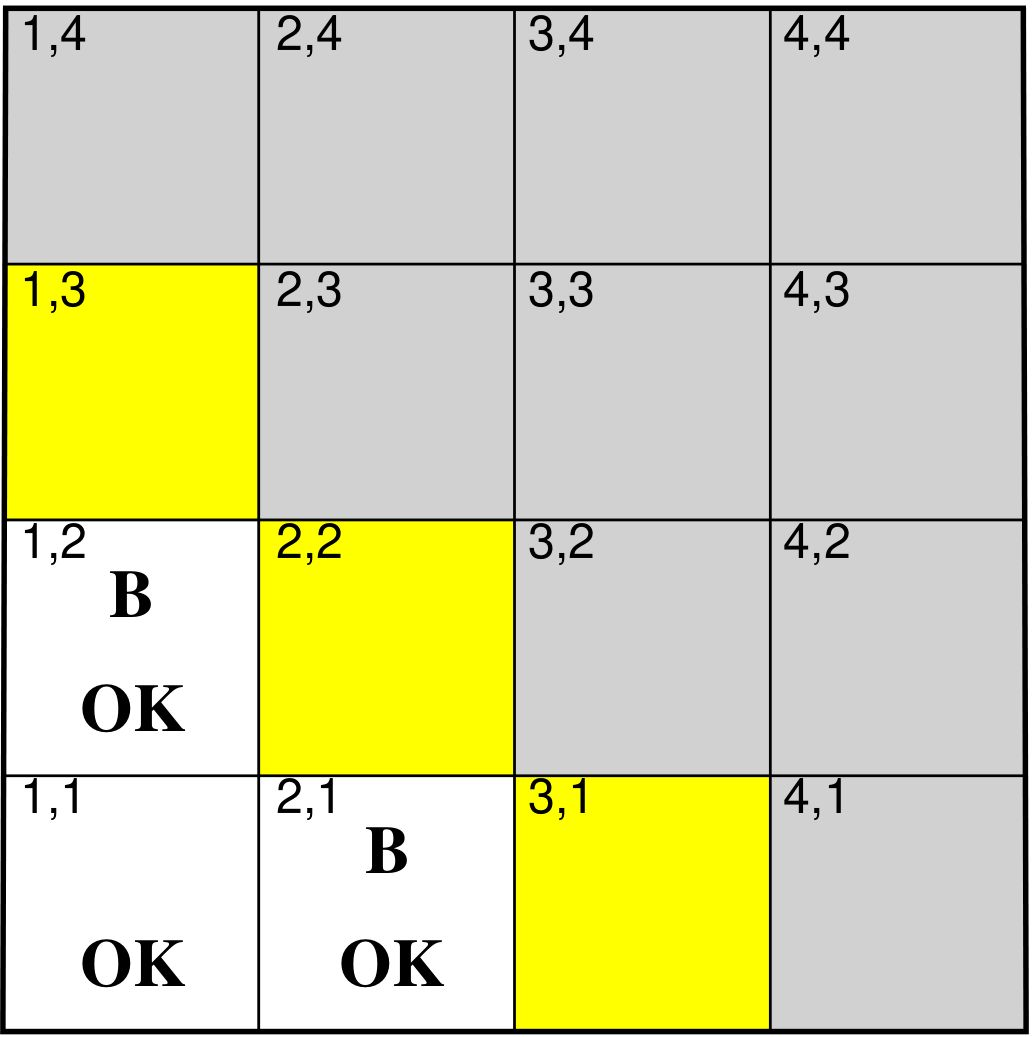

In [45]:
b_cpds = {
    (1,1): wumpus_cpd('B11', ['P12', 'P21'], lambda p12, p21: (p12 or p21)),
    (1,2): wumpus_cpd('B12', ['P11', 'P13', 'P22'], lambda p11, p13, p22: (p11 or p13 or p22)),
    (2,1): wumpus_cpd('B21', ['P11', 'P22', 'P31'], lambda p11, p22, p31: (p11 or p22 or p31)),
    (2,2): wumpus_cpd('B22', ['P12', 'P21', 'P32', 'P23'], lambda p12, p21, p32, p23: (p12 or p21 or p32 or p23))
}

for t in b_cpds.values():
    print(t)


+------------+-----------+------------+------------+------------+
| P12        | P12(True) | P12(True)  | P12(False) | P12(False) |
+------------+-----------+------------+------------+------------+
| P21        | P21(True) | P21(False) | P21(True)  | P21(False) |
+------------+-----------+------------+------------+------------+
| B11(True)  | 1.0       | 1.0        | 1.0        | 0.0        |
+------------+-----------+------------+------------+------------+
| B11(False) | 0.0       | 0.0        | 0.0        | 1.0        |
+------------+-----------+------------+------------+------------+
+------------+-----------+-----+------------+------------+
| P11        | P11(True) | ... | P11(False) | P11(False) |
+------------+-----------+-----+------------+------------+
| P13        | P13(True) | ... | P13(False) | P13(False) |
+------------+-----------+-----+------------+------------+
| P22        | P22(True) | ... | P22(True)  | P22(False) |
+------------+-----------+-----+------------+-------

In [23]:
exp_model = BayesianNetwork()

for b in b_cpds.values():
    for e in b.get_evidence(): 
        exp_model.add_edge(e, b.variable)
        
exp_model.add_nodes_from([p.variable for p in p_cpds.values()])
        
exp_model.add_cpds(*b_cpds.values())
exp_model.add_cpds(*p_cpds.values())

assert exp_model.check_model()

exp_infer = VariableElimination(exp_model)

In [24]:
exp_model.get_cpds()

[<TabularCPD representing P(B11:2 | P12:2, P21:2) at 0x1e442c14d48>,
 <TabularCPD representing P(B12:2 | P11:2, P13:2, P22:2) at 0x1e442c14dc8>,
 <TabularCPD representing P(B21:2 | P11:2, P22:2, P31:2) at 0x1e442c14c08>,
 <TabularCPD representing P(P11:2) at 0x1e441524dc8>,
 <TabularCPD representing P(P12:2) at 0x1e441524f08>,
 <TabularCPD representing P(P13:2) at 0x1e441527048>,
 <TabularCPD representing P(P21:2) at 0x1e441527148>,
 <TabularCPD representing P(P22:2) at 0x1e441527248>,
 <TabularCPD representing P(P23:2) at 0x1e441527348>,
 <TabularCPD representing P(P31:2) at 0x1e441527448>,
 <TabularCPD representing P(P32:2) at 0x1e441527548>,
 <TabularCPD representing P(P33:2) at 0x1e441527648>]

In [ ]:
# thfrom pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableEliminationis requires matplotlib
import matplotlib.pyplot as plt
nx.draw(exp_model, pos=nx.planar_layout(exp_model), with_labels=True)

In [1]:
for v in ('P13', 'P22', 'P31'):
    print(exp_infer.query([v], evidence={'B11': False, 'B12': True, 'B21': True, 'P11': False, 'P12': False, 'P21': False}, show_progress=False))

NameError: name 'exp_infer' is not defined